# Diferenciacion automatica

Supongamos que necesitamos encontrar derivadas de la funcion $F(x)=(5x+1)^2$

Si descomponemos la funci\'on $F(x)=f(g(x))$, donde $f(x)=x^2$ y $g(x)=5x+1$ entonces podemos calcular la derivada de $\frac{\partial F(x)}{\partial x}$ como:

\begin{align}
\frac{\partial F(x)}{\partial x}=\frac{\partial f(g(x))}{\partial g(x)} \times \frac{\partial g(x)}{\partial x}
\end{align}

In [3]:
import jax.numpy as jnp
from jax import grad

def g(x):
  return 5*x+1

def f(x):
    return x**2

def h(x):
  return f(g(x))

grad_h = grad(h)

print ('F(X) : %.6f'%h(1.0))
print ('dF/dx : %.6f'%grad_h(1.0))

F(X) : 36.000000
dF/dx : 60.000000


$\frac{\partial f(g(x))}{\partial g(x)}=2 g(x)$

$\frac{\partial g(x)}{\partial x}=5$

In [4]:
dfdg_dgfx=2*g(1.0)*5
print('Derivada Exacta : %.6f'%dfdg_dgfx)

Derivada Exacta : 60.000000


### Modelo Lineal con Diferenciacion automatica

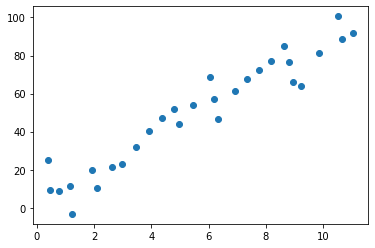

In [5]:
from jax import random 
import matplotlib.pyplot as plt


# Training data
key=random.PRNGKey(0)
data_key,data_key=random.split(key,2)
num_points=30
scale=10
X = jnp.linspace(0,11,num=num_points)+0.2*random.normal(data_key,(num_points,))
#X=0.2*random.normal(data_key,(num_points,))
y = jnp.asarray([8.0*x + 2.0 for x in X]) + scale*random.normal(data_key,(num_points,))

plt.scatter(X,y)

In [29]:
def rmse(y_true,y_hat):
  return jnp.sqrt(jnp.mean((y_true-y_hat)**2))

def net(X,params):
  return jnp.dot(jnp.expand_dims(X,axis=-1),params['weight'])+params['bias']

def training_loss(par):
  y_hat=net(X,par)
  return rmse(y,y_hat)

In [30]:
def random_layer_params(key,input_dim=1, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key,(input_dim,)), scale * random.normal(b_key, (1,))

def init_model_params(model_key,input_dim=1):
  params=dict()
  params['weight'],params['bias']=random_layer_params(model_key,input_dim, scale=1e-2)
  return params 

model_key=random.PRNGKey(32)
params=init_model_params(model_key)


In [31]:
params

{'weight': Array([0.00427488], dtype=float32),
 'bias': Array([0.01142025], dtype=float32)}

In [243]:
training_loss(params)

Array(10.491742, dtype=float32)

In [244]:
grad_theta=grad(training_loss)

In [246]:
grad_theta(params)

{'bias': Array([-0.15890956], dtype=float32),
 'weight': Array([-1.1688148], dtype=float32)}

In [247]:
def train_net(par,iterations,eta=0.1):
    loss_history=[]
    for i in range(iterations):
      grad=grad_theta(par)
      for var in par.keys():
        par[var] -= grad[var] * eta
      loss_history.append(training_loss(par))
      if i%(iterations/10)==0:
        print("Iteration : {0}, Trained loss: {1:0.4f}".format(i,training_loss(par)))
    return par,loss_history

In [248]:
params,loss=train_net(params,10000,eta=1e-2)

Iteration : 0, Trained loss: 10.4778
Iteration : 1000, Trained loss: 1.5087
Iteration : 2000, Trained loss: 1.5039
Iteration : 3000, Trained loss: 1.5015
Iteration : 4000, Trained loss: 1.4994
Iteration : 5000, Trained loss: 1.4975
Iteration : 6000, Trained loss: 1.4958
Iteration : 7000, Trained loss: 1.4942
Iteration : 8000, Trained loss: 1.4929
Iteration : 9000, Trained loss: 1.4916


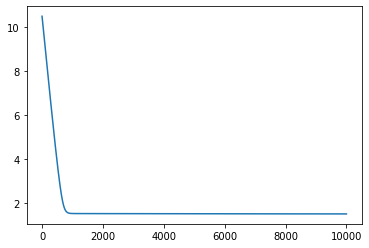

In [249]:
plt.plot(loss)

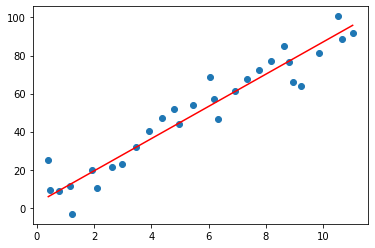

In [250]:
y_hat=net(X,params)

plt.scatter(X,y)
plt.plot(X,y_hat,'r-')

In [251]:
params

{'weight': Array([8.469029], dtype=float32),
 'bias': Array([2.4307249], dtype=float32)}

# Redes Neuronales

Ahora en el contexto del aprendizaje automatico, queremos eoncontrar derivadas parciales de una funcion objetivo con respecto a los parametros del modelo. En el caso de problemas de clasificacion binaria multi-variable contamos con datos de entrada $\textbf X=(\mathbf x_1,\ldots,\mathbf x_n)$ y sus correspondientes etiquetas $\textbf y=(y_1,\ldots,y_n)$.

Para cada tupla $(x_i,y_i)$ podemos establecer la siguiente relacion lineal:

\begin{align}
\text{log}\left(\frac{p( C=1 \vert \mathbf x_i )}{p(C=0 \vert \mathbf x_i )} \right)&=w_0+\sum_{j=1}^{d} w_j\,x_{ij}\\
&=\mathbf w^T \mathbf x_i
\end{align}  

Al mismo tiempo , podemos obtener las probabilidades condicionales para cada clase:

\begin{align}
p(C=1\vert \textbf x_i)&= \phi(\mathbf w^T \mathbf x_i)=\frac{\text{exp}(\mathbf w^T \mathbf x_i)}{1+\text{exp}(\mathbf w^T \mathbf x_i)}
\end{align} 

Donde $\phi(\cdot)$ es la llamada función sigmoide.

La funcion sigmoide convierte cualquier entrada $\mathbf w^T \mathbf x_i \in [-\inf,\inf]$ hacia el intervalo $(0,1)$, por lo tanto podemos utilizar la funcion de verosimilitud de la distribucion de Bernoulli para comparar las probabilidad de clase con las etiquetas binarias:

\begin{align}
p(\textbf y, \textbf X,\mathbf w)= \prod_{i=1}^N (\phi(\mathbf w^T \mathbf x_i))^{y_i} \times (1-\phi(\mathbf w^T \mathbf x_i))^{1-y_i}
\end{align}

Ahora queremos obtener los parametros $\hat{\mathbf w}$ que maximicen la verosimilitud $p(\textbf y, \textbf X,\mathbf w)$. Dado que la funcion logaritmo es monotona en todo el dominio $[-\inf,\inf]$ utilizamos $\operatorname{log} p(\textbf y, \textbf X,\mathbf w)$ como funcion objetivo (log-loss):

\begin{align}
L(\mathbf w)=\sum_{i=1}^N (y_i \operatorname{log} \phi(\mathbf w^T \mathbf x_i)) + ({1-y_i}) \operatorname{log} (1-\phi(\mathbf w^T \mathbf x_i))
\end{align}

Ahora que tenemos definida una funcion objetivo, podemos evaluar iterativamente los pesos $w$ escogiendo la direccion de maximo crecimiento (gradiente).

\begin{align}
\mathbf w^{j+1}= \mathbf  w^j-\eta \frac{\partial L(\mathbf w)}{\partial \mathbf w}
\end{align}

Donde $\eta > 0$ es un factor de descuento o tasa de aprendizaje.

In [252]:
import matplotlib.pyplot as plt

def sigmoid(x):
    return jnp.exp(x)/(1+jnp.exp(x))

def net(params,X):
    logits =  jnp.dot(X,params['weight'])+params['bias']
    return sigmoid(logits)

def training_loss(params):
    # Training loss is the negative log-likelihood of the training labels.
    y_hat = net(params, X)
    label_probabilities = jnp.log(y_hat) * y + jnp.log((1 - y_hat)) * (1 - y)
    return -jnp.sum(label_probabilities)

# Build a function that returns gradients of training loss using autograd.
grad_theta = grad(training_loss)

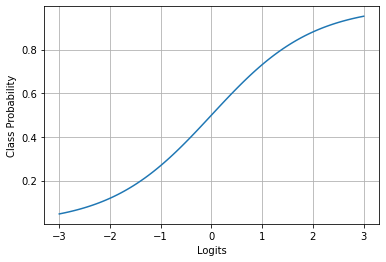

In [253]:
x=jnp.linspace(-3,3,num=100)
plt.plot(x,sigmoid(x))
plt.xlabel("Logits")
plt.ylabel("Class Probability")
plt.grid()

In [254]:
# Build a toy dataset.
X = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
y = jnp.array([False, True, False, True])

In [255]:
def random_layer_params(key,input_dim=1, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key,(input_dim,)), scale * random.normal(b_key, (1,))

def init_model_params(random_key,n_in):
  params=dict()
  params['weight'],params['bias']=random_layer_params(random_key,input_dim=n_in)
  return params 

model_key=random.PRNGKey(64)
params=init_model_params(model_key,n_in=X.shape[-1])

In [256]:
params['weight'],params['bias']

(Array([-0.0004321 , -0.02125132,  0.00091266], dtype=float32),
 Array([0.00686422], dtype=float32))

In [257]:
y_hat=net(params,X)

In [258]:
params,loss=train_net(params,1000,eta=1e-2)

Iteration : 0, Trained loss: 2.6576
Iteration : 100, Trained loss: 0.9315
Iteration : 200, Trained loss: 0.5906
Iteration : 300, Trained loss: 0.4330
Iteration : 400, Trained loss: 0.3412
Iteration : 500, Trained loss: 0.2811
Iteration : 600, Trained loss: 0.2386
Iteration : 700, Trained loss: 0.2071
Iteration : 800, Trained loss: 0.1828
Iteration : 900, Trained loss: 0.1635


In [259]:
params

{'weight': Array([ 0.05144963, -3.1799924 ,  1.408055  ], dtype=float32),
 'bias': Array([-0.89930874], dtype=float32)}

Text(0, 0.5, 'x2')

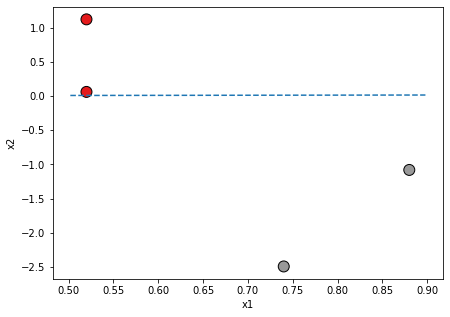

In [260]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7,5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,edgecolor='k',s=120)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

def line(x0):
   return (-(x0 * params['weight'][0]) ) / params['weight'][1]

plt.plot([xmin, xmax], [line(xmin), line(xmax)],ls="--")
plt.xlabel('x1')
plt.ylabel('x2')


# Redes Neuronales Profundas

Una alternativa para superar el problema de la separacion lineal entre clases es utilizar multiples perceptrones ordenados en capas

La salida toma la siguiente forma:
\begin{align*}
f(\mathbf x) = \phi_0 \left(w_0+\sum_h w_{hk}\phi_h (\alpha_h+\sum_i w_{ih}x_i) \right)
\end{align*}

### Preparación de Datos

In [6]:
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(noise=0.352, random_state=1, n_samples=500)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

Text(0.5, 0.98, 'Train Test Datasets')

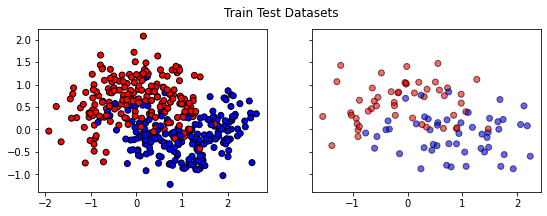

In [7]:
from matplotlib.colors import ListedColormap

cm_bright = ListedColormap(["#FF0000", "#0000FF"])

fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
axs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
# Plot the testing points
axs[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
fig.suptitle('Train Test Datasets')

In [8]:
data_preprocessing=False

if data_preprocessing:
    X_train=(X_train-jnp.min(X_train,axis=0))/(jnp.max(X_train,axis=0)-jnp.min(X_train,axis=0))
    X_test=(X_test-jnp.min(X_train,axis=0))/(jnp.max(X_train,axis=0)-jnp.min(X_train,axis=0))

### Selección del Modelo

In [9]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(layer_widths, key):
  params = {}
  keys = random.split(key, len(layer_widths))
  params = {}
  for i, (n_in, n_out, key) in enumerate(zip(layer_widths[:-1], layer_widths[1:], keys)):
    params[f"weight_{i}"],params[f"bias_{i}"]=random_layer_params(n_in, n_out, key, scale=1) 
  return params


In [10]:
layer_sizes = [2, 5, 5, 1]
params = init_network_params(layer_sizes, random.PRNGKey(64))

In [11]:
import jax  

jax.tree_map(lambda p : p.shape,params)

{'bias_0': (5,),
 'bias_1': (5,),
 'bias_2': (1,),
 'weight_0': (2, 5),
 'weight_1': (5, 5),
 'weight_2': (5, 1)}

In [13]:
def sigmoid(x):
    return jnp.exp(x)/(1+jnp.exp(x))

activations=X_train[:10,:]
activations=jnp.dot(activations,params['weight_0'])+params['bias_0']
activations=jnp.tanh(activations)
activations=jnp.dot(activations,params['weight_1'])+params['bias_1']
activations=jnp.tanh(activations)
activations=jnp.dot(activations,params['weight_2'])+params['bias_2']
output=sigmoid(activations)
#output=sigmoid(activations)


In [14]:
def relu(x):
  return jnp.maximum(0, x)

def deep_net(params,layer_sizes, X):
  # per-example predictions
  activations = X
  num_layers=len(layer_sizes)-2
  for i in range(num_layers-1):
    outputs = jnp.dot(activations,params[f'weight_{i}']) + params[f'bias_{i}']
    activations = jnp.tanh(outputs)
  logits = jnp.dot(activations,params[f'weight_{num_layers}']) + params[f'bias_{num_layers}']
  return sigmoid(logits)

In [15]:
def training_loss(params):
    # Training loss is the negative log-likelihood of the training labels.
    y_hat = deep_net(params,layer_sizes, X_train)
    label_probabilities = jnp.log(y_hat) * y_train + jnp.log((1 - y_hat)) * (1 - y_train)
    return -jnp.mean(label_probabilities)

# Build a function that returns gradients of training loss using autograd.
grad_theta = jax.grad(training_loss)

In [16]:
def train_deep_net(par,iterations,eta=0.1):
    loss_history=[]
    for i in range(iterations):
      grad=grad_theta(par)
      for var in par.keys():
        par[var] -= grad[var] * eta
      loss_history.append(training_loss(par))
      if i%(iterations/10)==0:
        print("Iteration : {0}, Trained loss: {1:0.4f}".format(i,training_loss(par)))
    return par,loss_history

In [17]:
params,loss=train_deep_net(params,10000,eta=1e-5)

Iteration : 0, Trained loss: 1.0015
Iteration : 1000, Trained loss: 0.9989
Iteration : 2000, Trained loss: 0.9963
Iteration : 3000, Trained loss: 0.9937
Iteration : 4000, Trained loss: 0.9911
Iteration : 5000, Trained loss: 0.9886
Iteration : 6000, Trained loss: 0.9861
Iteration : 7000, Trained loss: 0.9835
Iteration : 8000, Trained loss: 0.9810
Iteration : 9000, Trained loss: 0.9785


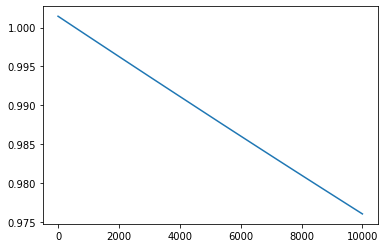

In [18]:
plt.plot(loss)

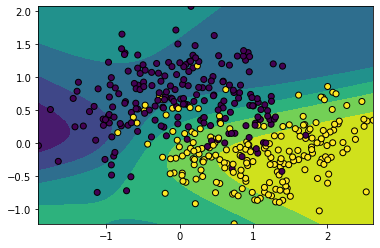

In [21]:
from sklearn.inspection import DecisionBoundaryDisplay
import numpy as np 

feature_1, feature_2 = np.meshgrid(
        np.linspace(X_train[:, 0].min(), X_train[:, 0].max()),
        np.linspace(X_train[:, 1].min(), X_train[:, 1].max())
        )
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
y_pred= np.reshape(deep_net(params,layer_sizes, grid), feature_1.shape)
display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
display.plot()
display.ax_.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor="black")
plt.show()

# Evaluación y Selección de Modelo

Para evaluar el modelo podemos usar las metricas de Exactitud (accuracy)

$\texttt{accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)$



In [22]:
y_hat=deep_net(params,layer_sizes,X_test)
np.sum(y_test==(y_hat>0.5).reshape(-1))/len(y_test)

Array(0.85, dtype=float32)

In [23]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, (y_hat>0.5).reshape(-1))
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.850


La precisión mide la proporción de instancias positivas correctamente identificadas entre todas las instancias identificadas como positivas. Se centra en la calidad de las predicciones positivas 

$\texttt{precision}(y, \hat{y}) =\frac{TP}{TP+FP}$.


La recuperación mide la proporción de instancias positivas correctamente identificadas entre todas las instancias que son realmente positivas. Se centra en la capacidad del modelo para capturar todas las instancias positivas.

$\texttt{recall}(y, \hat{y}) =\frac{TP}{TP+FN}$.

Verdaderos Positivos (TP): Instancias que fueron clasificadas correctamente como positivas por el modelo.
Falsos Positivos (FP): Instancias que fueron clasificadas incorrectamente como positivas por el modelo (en realidad son negativas).
Verdaderos Negativos (TN): Instancias que fueron clasificadas correctamente como negativas por el modelo.
Falsos Negativos (FN): Instancias que fueron clasificadas incorrectamente como negativas por el modelo (en realidad son positivas).


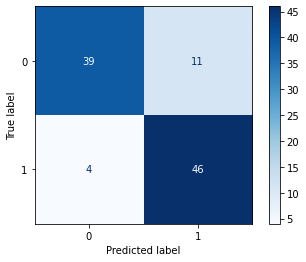

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_hat>0.5,cmap=plt.cm.Blues)

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_hat>0.5))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84        50
           1       0.81      0.92      0.86        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



In [27]:
r_0=39/(39+11)
r_1=46/(46+4)
print("Recall Clase 0 : {0:0.2f}, Recall Clase 1 : {1:0.2f}".format(r_0,r_1))

Recall Clase 0 : 0.78, Recall Clase 1 : 0.92


In [28]:
p_0=39/(39+4)
p_1=46/(46+11)
print("Precision Clase 0 : {0:0.2f}, Precision Clase 1 : {1:0.2f}".format(p_0,p_1))

Precision Clase 0 : 0.91, Precision Clase 1 : 0.81
